In [1]:
 import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from tqdm import trange

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv("datasets/customer_dataframe.csv", sep="\t", index_col=0)
df.head()

,TProd,DProd,MaxPO,MinPO,MeanProdOrder,TSale,MinPSale,MaxPSale,MeanSaleOrder,TRProd,MeanPSale,TOrder,SETSaleQta,SESaleQtaOrder
CustomerID,,,,,,,,,,,,,,
17850,1702,21,141,12,48.629,5317.89,6.36,107.25,151.940,31,3.960,34,4.137,3.186
13047,1355,105,309,3,84.688,3089.10,6.64,68.00,193.069,35,3.926,9,5.421,3.875
12583,4978,114,714,100,292.824,6629.34,6.80,132.80,389.961,50,2.140,15,5.804,4.087
13748,439,24,208,8,87.800,948.25,9.36,204.00,189.650,0,3.996,5,4.080,2.322
15100,58,1,32,16,9.667,635.10,175.20,350.40,105.850,22,10.950,3,2.252,2.252


In [3]:
df_aux = df[['TProd', 'MeanProdOrder', 'MeanSaleOrder', 'MeanPSale']]
df_aux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4333 entries, 17850 to 12713
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TProd          4333 non-null   int64  
 1   MeanProdOrder  4333 non-null   float64
 2   MeanSaleOrder  4333 non-null   float64
 3   MeanPSale      4333 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 169.3 KB


In [4]:
df_aux.describe()

,TProd,MeanProdOrder,MeanSaleOrder,MeanPSale
count,4333.000000,4333.000000,4333.000000,4333.000000
mean,1129.535657,201.104614,327.882896,3.492819
std,4692.695935,274.590134,395.336014,8.997404
min,0.000000,0.000000,-0.000000,0.122000
25%,157.000000,80.500000,155.050000,2.160000
50%,370.000000,140.167000,241.900000,2.834000
75%,971.000000,237.750000,371.560000,3.712000
max,196556.000000,7824.000000,9904.875000,434.650000


In [5]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df_aux.values)

In [6]:
X[:2]

array([[0.00865911, 0.00621536, 0.01533992, 0.00883257],
       [0.00689371, 0.01082413, 0.01949232, 0.00875433]])

In [7]:
# from the hierarchical clustering defined by the given linkage matrix and threshold return the cluster topology
def count_cluster_elements(data, threshold, criterion='distance'):
    count = {}
    clusters = fcluster(data, threshold, criterion)
    for c in clusters:
        count[c] = count[c]+1 if c in count else 1
    return count, clusters

In [8]:
# from flat clusters returns dictionary of dataframes representing the cluster
def get_dataframe(complete_df, flat_cluster):
    distinct_clusters = list(set(flat_cluster))
    sorted(distinct_clusters)
    cluster_index = {c:[] for c in distinct_clusters} 
    for i in range(len(flat_cluster)):
        cluster_index[flat_cluster[i]].append(i)
    clusters_df = {}
    indexes = df.index
    for c in distinct_clusters:
        elem = cluster_index[c]
        clusters_df[c] = df[df.index.isin([indexes[i] for i in elem])]
    return clusters_df

In [9]:
methods_silhouette = {}

In [10]:
# Complete - Euclidean

Text(0.5, 1.0, 'Complete - Euclidean')

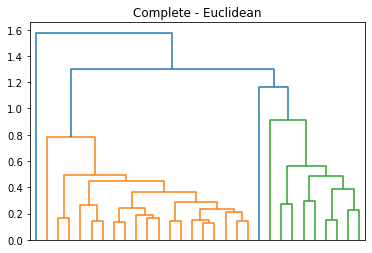

In [11]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
threshold_value = 1.0
res = dendrogram(data_link, color_threshold=threshold_value, truncate_mode='lastp')
plt.tick_params(labelbottom=False)
plt.title("Complete - Euclidean")

In [12]:
conta, clusters = count_cluster_elements(data_link, threshold_value)
print("Clusters:", len(conta.keys()))
print(list(reversed(sorted(conta.values()))))

Clusters: 4
[4311, 20, 1, 1]


In [13]:
score = silhouette_score(X, clusters)
methods_silhouette["complete"] = round(score, 2)
score

0.9229675968079302

In [14]:
cdf = get_dataframe(df, clusters)
for cluster, cluster_df in cdf.items():
    print(f"*********** Cluster {cluster} - {len(cluster_df)} ***********")
    #print(cluster_df.describe())

*********** Cluster 1 - 4311 ***********
*********** Cluster 2 - 20 ***********
*********** Cluster 3 - 1 ***********
*********** Cluster 4 - 1 ***********


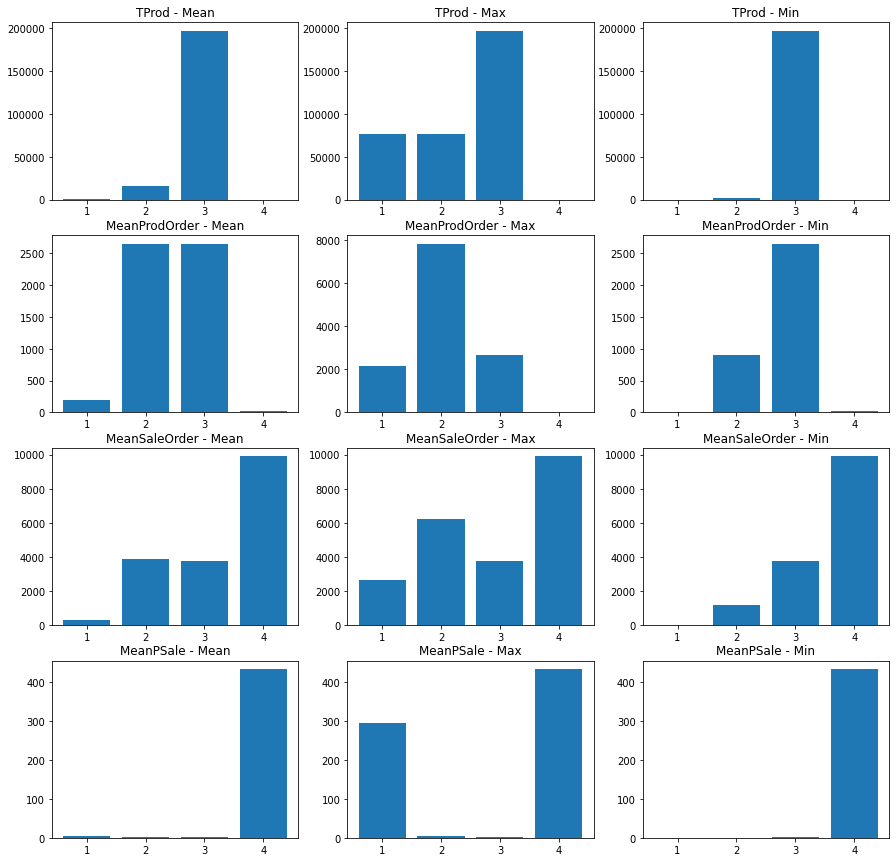

In [15]:
attr = df_aux.columns
clusters = [i for i in cdf]
fig, axs = plt.subplots(len(attr),3,figsize=(15,15))
for attr_index in range(len(attr)):
    mean_values = []
    max_values = []
    min_values = []
    for _, cluster_df in cdf.items():
        mean_values.append(cluster_df.describe()[attr[attr_index]][1])
        max_values.append(cluster_df.describe()[attr[attr_index]][7])
        min_values.append(cluster_df.describe()[attr[attr_index]][3])
    axs[attr_index][0].bar(clusters, mean_values)
    axs[attr_index][0].set_title(f"{attr[attr_index]} - Mean")
    axs[attr_index][1].bar(clusters, max_values)
    axs[attr_index][1].set_title(f"{attr[attr_index]} - Max")
    axs[attr_index][2].bar(clusters, min_values)
    axs[attr_index][2].set_title(f"{attr[attr_index]} - Min")

In [16]:
# Single - Euclidean

Text(0.5, 1.0, 'Single - Euclidean')

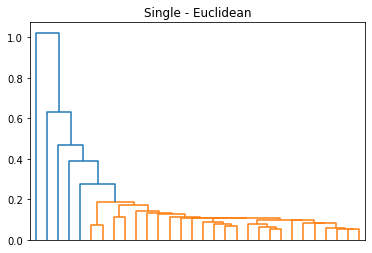

In [17]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='single', metric='euclidean')
threshold_value = 0.2
res = dendrogram(data_link, color_threshold=threshold_value, truncate_mode='lastp')
plt.tick_params(labelbottom=False)
plt.title("Single - Euclidean")

In [18]:
conta, clusters = count_cluster_elements(data_link, threshold_value)
print("Clusters:", len(conta.keys()))
print(list(reversed(sorted(conta.values()))))

Clusters: 6
[4328, 1, 1, 1, 1, 1]


In [19]:
score = silhouette_score(X, clusters)
methods_silhouette["single"] = round(score, 2)
score

0.9350227049491753

In [20]:
cdf = get_dataframe(df, clusters)
for cluster, cluster_df in cdf.items():
    print(f"*********** Cluster {cluster} - {len(cluster_df)} ***********")
    #print(cluster_df.describe())

*********** Cluster 1 - 4328 ***********
*********** Cluster 2 - 1 ***********
*********** Cluster 3 - 1 ***********
*********** Cluster 4 - 1 ***********
*********** Cluster 5 - 1 ***********
*********** Cluster 6 - 1 ***********


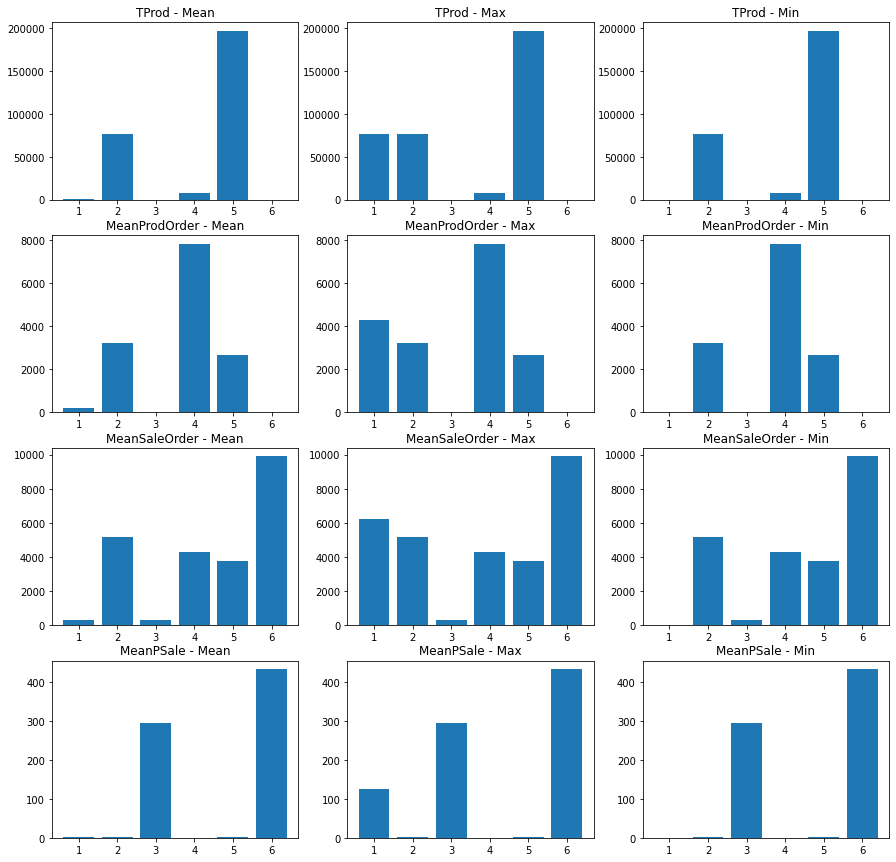

In [21]:
attr = ['TProd', 'MeanProdOrder', 'MeanSaleOrder', 'MeanPSale']
clusters = [i for i in cdf]
fig, axs = plt.subplots(len(attr),3,figsize=(15,15))
for attr_index in range(len(attr)):
    mean_values = []
    max_values = []
    min_values = []
    for _, cluster_df in cdf.items():
        mean_values.append(cluster_df.describe()[attr[attr_index]][1])
        max_values.append(cluster_df.describe()[attr[attr_index]][7])
        min_values.append(cluster_df.describe()[attr[attr_index]][3])
    axs[attr_index][0].bar(clusters, mean_values)
    axs[attr_index][0].set_title(f"{attr[attr_index]} - Mean")
    axs[attr_index][1].bar(clusters, max_values)
    axs[attr_index][1].set_title(f"{attr[attr_index]} - Max")
    axs[attr_index][2].bar(clusters, min_values)
    axs[attr_index][2].set_title(f"{attr[attr_index]} - Min")

In [22]:
# Avereage - Euclidean

Text(0.5, 1.0, 'Average - Euclidean')

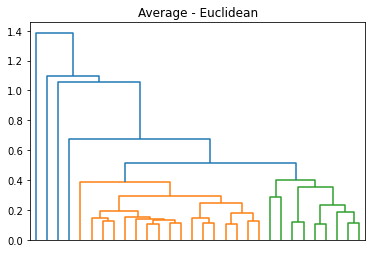

In [23]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')
threshold_value = 0.5
res = dendrogram(data_link, color_threshold=threshold_value, truncate_mode='lastp')
plt.tick_params(labelbottom=False)
plt.title("Average - Euclidean")

In [24]:
conta, clusters = count_cluster_elements(data_link, threshold_value)
print("Clusters:", len(conta.keys()))
print(list(reversed(sorted(conta.values()))))

Clusters: 6
[4312, 17, 1, 1, 1, 1]


In [25]:
score = silhouette_score(X, clusters)
methods_silhouette["average"] = round(score, 2)
score

0.9206974421486209

In [26]:
cdf = get_dataframe(df, clusters)
for cluster, cluster_df in cdf.items():
    print(f"*********** Cluster {cluster} - {len(cluster_df)} ***********")
    #print(cluster_df.describe())

*********** Cluster 1 - 4312 ***********
*********** Cluster 2 - 17 ***********
*********** Cluster 3 - 1 ***********
*********** Cluster 4 - 1 ***********
*********** Cluster 5 - 1 ***********
*********** Cluster 6 - 1 ***********


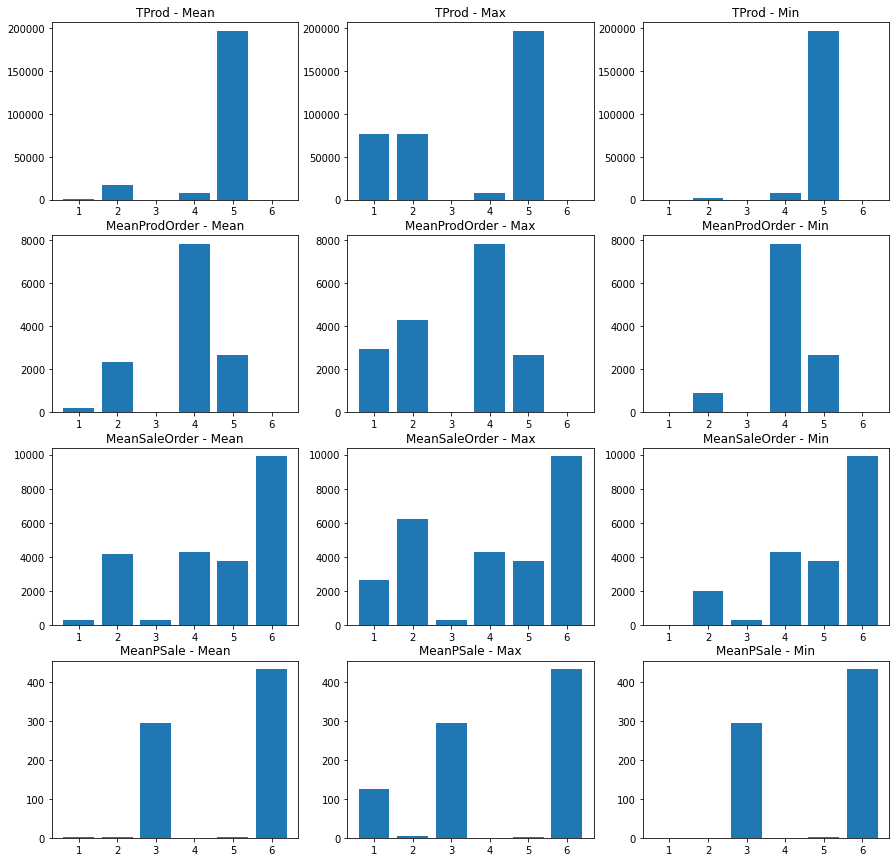

In [27]:
attr = ['TProd', 'MeanProdOrder', 'MeanSaleOrder', 'MeanPSale']
clusters = [i for i in cdf]
fig, axs = plt.subplots(len(attr),3,figsize=(15,15))
for attr_index in range(len(attr)):
    mean_values = []
    max_values = []
    min_values = []
    for _, cluster_df in cdf.items():
        mean_values.append(cluster_df.describe()[attr[attr_index]][1])
        max_values.append(cluster_df.describe()[attr[attr_index]][7])
        min_values.append(cluster_df.describe()[attr[attr_index]][3])
    axs[attr_index][0].bar(clusters, mean_values)
    axs[attr_index][0].set_title(f"{attr[attr_index]} - Mean")
    axs[attr_index][1].bar(clusters, max_values)
    axs[attr_index][1].set_title(f"{attr[attr_index]} - Max")
    axs[attr_index][2].bar(clusters, min_values)
    axs[attr_index][2].set_title(f"{attr[attr_index]} - Min")

In [28]:
# Ward - Euclidean

Text(0.5, 1.0, 'Ward - Euclidean')

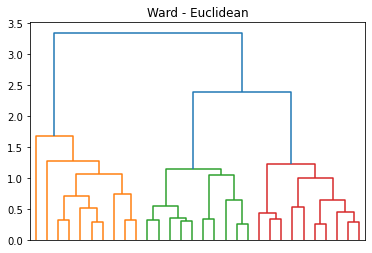

In [29]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='ward', metric='euclidean')
threshold_value = 2.0
res = dendrogram(data_link, color_threshold=threshold_value, truncate_mode='lastp')
plt.tick_params(labelbottom=False)
plt.title("Ward - Euclidean")

In [30]:
conta, clusters = count_cluster_elements(data_link, threshold_value)
print("Clusters:", len(conta.keys()))
print(list(reversed(sorted(conta.values()))))

Clusters: 3
[3853, 458, 22]


In [31]:
score = silhouette_score(X, clusters)
methods_silhouette["ward"] = round(score, 2)
score

0.6717133967267056

In [32]:
cdf = get_dataframe(df, clusters)
for cluster, cluster_df in cdf.items():
    print(f"*********** Cluster {cluster} - {len(cluster_df)} ***********")
    #print(cluster_df.describe())

*********** Cluster 1 - 22 ***********
*********** Cluster 2 - 3853 ***********
*********** Cluster 3 - 458 ***********


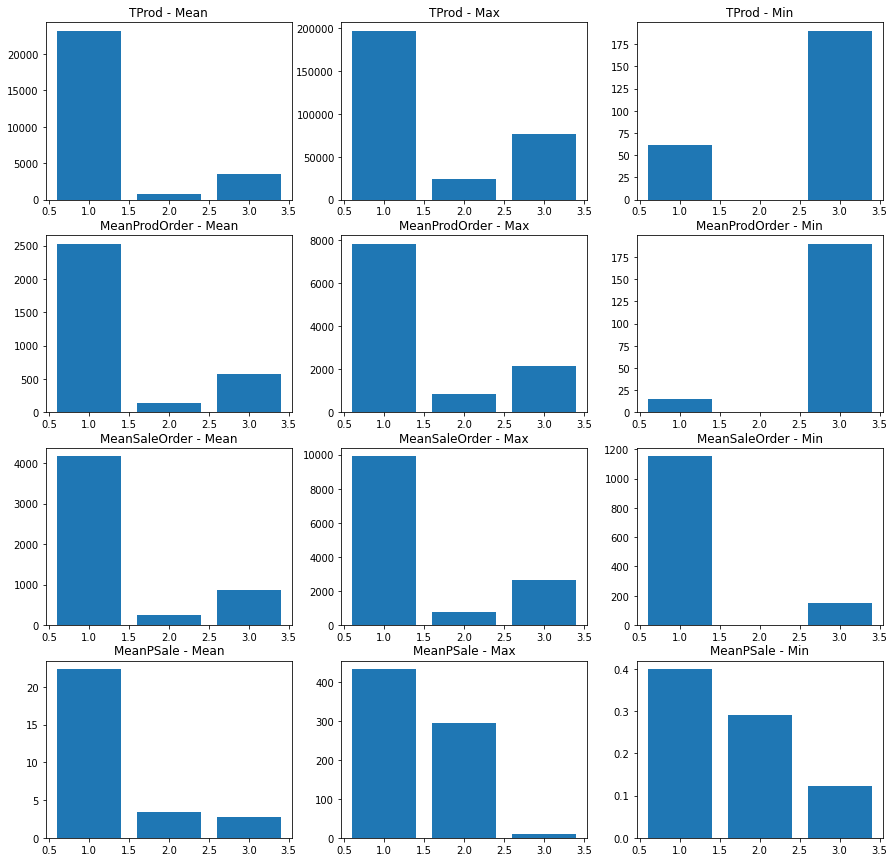

In [46]:
attr = ['TProd', 'MeanProdOrder', 'MeanSaleOrder', 'MeanPSale']
clusters = [i for i in cdf]
fig, axs = plt.subplots(len(attr),3,figsize=(15,15))
for attr_index in range(len(attr)):
    mean_values = []
    max_values = []
    min_values = []
    for _, cluster_df in cdf.items():
        mean_values.append(cluster_df.describe()[attr[attr_index]][1])
        max_values.append(cluster_df.describe()[attr[attr_index]][7])
        min_values.append(cluster_df.describe()[attr[attr_index]][3])
    axs[attr_index][0].bar(clusters, mean_values)
    axs[attr_index][0].set_title(f"{attr[attr_index]} - Mean")
    axs[attr_index][1].bar(clusters, max_values)
    axs[attr_index][1].set_title(f"{attr[attr_index]} - Max")
    axs[attr_index][2].bar(clusters, min_values)
    axs[attr_index][2].set_title(f"{attr[attr_index]} - Min")

In [34]:
# ----------------------------------------------

In [35]:
methods_silhouette

{'complete': 0.92, 'single': 0.94, 'average': 0.92, 'ward': 0.67}

In [36]:
# ----------------------------------------------

In [37]:
from sklearn.cluster import AgglomerativeClustering
connectivity=None

In [38]:
for i in range(2, 10):
    complete = AgglomerativeClustering(n_clusters=i, linkage='complete', affinity='euclidean', connectivity=connectivity)
    complete.fit(X)
    hist, bins = np.histogram(complete.labels_, bins=range(0, len(set(complete.labels_)) + 1))
    
    print('Numero Cluster: ', i)
    print('Cluster', dict(zip(bins, hist)))
    print('Silhouette Score', silhouette_score(X, complete.labels_))
    print()

Numero Cluster:  2
Cluster {0: 4332, 1: 1}
Silhouette Score 0.9687137721422231

Numero Cluster:  3
Cluster {0: 21, 1: 1, 2: 4311}
Silhouette Score 0.9265553774017546

Numero Cluster:  4
Cluster {0: 20, 1: 1, 2: 4311, 3: 1}
Silhouette Score 0.9229675968079302

Numero Cluster:  5
Cluster {0: 4311, 1: 1, 2: 19, 3: 1, 4: 1}
Silhouette Score 0.9187430059077543

Numero Cluster:  6
Cluster {0: 19, 1: 1, 2: 4310, 3: 1, 4: 1, 5: 1}
Silhouette Score 0.9188385985788512

Numero Cluster:  7
Cluster {0: 4310, 1: 1, 2: 14, 3: 1, 4: 1, 5: 1, 6: 5}
Silhouette Score 0.9170025935200273

Numero Cluster:  8
Cluster {0: 14, 1: 9, 2: 4301, 3: 1, 4: 1, 5: 1, 6: 5, 7: 1}
Silhouette Score 0.813657594677613

Numero Cluster:  9
Cluster {0: 4301, 1: 3, 2: 11, 3: 9, 4: 1, 5: 1, 6: 5, 7: 1, 8: 1}
Silhouette Score 0.8137404851058346



In [39]:
for i in range(2, 10):
    complete = AgglomerativeClustering(n_clusters=i, linkage='single', affinity='euclidean', connectivity=connectivity)
    complete.fit(X)
    hist, bins = np.histogram(complete.labels_, bins=range(0, len(set(complete.labels_)) + 1))
    
    print('Numero Cluster: ', i)
    print('Cluster', dict(zip(bins, hist)))
    print('Silhouette Score', silhouette_score(X, complete.labels_))
    print()

Numero Cluster:  2
Cluster {0: 4332, 1: 1}
Silhouette Score 0.9687137721422231

Numero Cluster:  3
Cluster {0: 4331, 1: 1, 2: 1}
Silhouette Score 0.9604297674001191

Numero Cluster:  4
Cluster {0: 4330, 1: 1, 2: 1, 3: 1}
Silhouette Score 0.9579502745851489

Numero Cluster:  5
Cluster {0: 4329, 1: 1, 2: 1, 3: 1, 4: 1}
Silhouette Score 0.9377329705254488

Numero Cluster:  6
Cluster {0: 4328, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1}
Silhouette Score 0.9350227049491753

Numero Cluster:  7
Cluster {0: 4326, 1: 1, 2: 2, 3: 1, 4: 1, 5: 1, 6: 1}
Silhouette Score 0.9172176178710767

Numero Cluster:  8
Cluster {0: 4323, 1: 3, 2: 2, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}
Silhouette Score 0.9178363087388205

Numero Cluster:  9
Cluster {0: 4321, 1: 3, 2: 2, 3: 2, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1}
Silhouette Score 0.9187295304199423



In [40]:
for i in range(2, 10):
    complete = AgglomerativeClustering(n_clusters=i, linkage='average', affinity='euclidean', connectivity=connectivity)
    complete.fit(X)
    hist, bins = np.histogram(complete.labels_, bins=range(0, len(set(complete.labels_)) + 1))
    
    print('Numero Cluster: ', i)
    print('Cluster', dict(zip(bins, hist)))
    print('Silhouette Score', silhouette_score(X, complete.labels_))
    print()

Numero Cluster:  2
Cluster {0: 4332, 1: 1}
Silhouette Score 0.9687137721422231

Numero Cluster:  3
Cluster {0: 4331, 1: 1, 2: 1}
Silhouette Score 0.9604297674001191

Numero Cluster:  4
Cluster {0: 4330, 1: 1, 2: 1, 3: 1}
Silhouette Score 0.9579502745851489

Numero Cluster:  5
Cluster {0: 4329, 1: 1, 2: 1, 3: 1, 4: 1}
Silhouette Score 0.9377329705254488

Numero Cluster:  6
Cluster {0: 17, 1: 1, 2: 4312, 3: 1, 4: 1, 5: 1}
Silhouette Score 0.9206974421486209

Numero Cluster:  7
Cluster {0: 4312, 1: 1, 2: 14, 3: 1, 4: 1, 5: 1, 6: 3}
Silhouette Score 0.917659219682286

Numero Cluster:  8
Cluster {0: 14, 1: 1, 2: 4311, 3: 1, 4: 1, 5: 1, 6: 3, 7: 1}
Silhouette Score 0.8985963963948641

Numero Cluster:  9
Cluster {0: 4311, 1: 3, 2: 3, 3: 1, 4: 1, 5: 1, 6: 11, 7: 1, 8: 1}
Silhouette Score 0.898256903355965



In [41]:
for i in range(2, 10):
    complete = AgglomerativeClustering(n_clusters=i, linkage='ward', affinity='euclidean', connectivity=connectivity)
    complete.fit(X)
    hist, bins = np.histogram(complete.labels_, bins=range(0, len(set(complete.labels_)) + 1))
    
    print('Numero Cluster: ', i)
    print('Cluster', dict(zip(bins, hist)))
    print('Silhouette Score', silhouette_score(X, complete.labels_))
    print()

Numero Cluster:  2
Cluster {0: 4311, 1: 22}
Silhouette Score 0.9308883038332841

Numero Cluster:  3
Cluster {0: 22, 1: 458, 2: 3853}
Silhouette Score 0.6717133967267056

Numero Cluster:  4
Cluster {0: 21, 1: 458, 2: 3853, 3: 1}
Silhouette Score 0.6721013455064441

Numero Cluster:  5
Cluster {0: 458, 1: 20, 2: 3853, 3: 1, 4: 1}
Silhouette Score 0.672383890211012

Numero Cluster:  6
Cluster {0: 3853, 1: 20, 2: 96, 3: 1, 4: 1, 5: 362}
Silhouette Score 0.5961630754857788

Numero Cluster:  7
Cluster {0: 20, 1: 1930, 2: 96, 3: 1, 4: 1, 5: 362, 6: 1923}
Silhouette Score 0.38930851224708113

Numero Cluster:  8
Cluster {0: 1930, 1: 6, 2: 96, 3: 14, 4: 1, 5: 362, 6: 1923, 7: 1}
Silhouette Score 0.3899327800455814

Numero Cluster:  9
Cluster {0: 96, 1: 6, 2: 10, 3: 14, 4: 1, 5: 362, 6: 1923, 7: 1, 8: 1920}
Silhouette Score 0.39569070662443645

